In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Imputación de nulos

In [5]:
# Revisión de valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())
print("\nPorcentaje de valores nulos por columna:")
print(data.isnull().sum()/len(data) * 100)

# Revisión de duplicados
duplicados = data.duplicated().sum()
print(f"\nNúmero de registros duplicados: {duplicados}")

# Revisión de tipos de datos
print("\nTipos de datos de las columnas:")
print(data.dtypes)

Valores nulos por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Porcentaje de valores nulos por columna:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Número de registros duplicados: 0

Tipos de datos de las columnas:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
# Poner la columna 'Age' mediante KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data['Age'] = imputer.fit_transform(data[['Age', 'Pclass', 'Fare']])[:, 0]

# Poner la columna 'Embarked' con la moda
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Poner la columna 'Cabin' con "Unknown" 
data['Cabin'] = data['Cabin'].fillna("Unknown")

# Feature Engineering

In [7]:
import re

def extraer_titulo_robusto(nombre):
    """
    Función robusta para extraer títulos/gentilicios de nombres completos.
    
    Parámetros:
    nombre (str): Nombre completo de la persona
    
    Retorna:
    str: Título extraído y normalizado
    """
    if pd.isna(nombre) or not isinstance(nombre, str):
        return 'Unknown'
    
    # Diccionario de mapeo para normalizar títulos
    titulo_mapping = {
        # Títulos masculinos
        'Mr': 'Mr',
        'Master': 'Master',
        'Rev': 'Rev',
        'Dr': 'Dr',
        'Major': 'Military',
        'Col': 'Military',
        'Capt': 'Military',
        'Sir': 'Nobility',
        'Don': 'Nobility',
        'Jonkheer': 'Nobility',
        
        # Títulos femeninos
        'Mrs': 'Mrs',
        'Miss': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs',
        'Mlle': 'Miss',
        'Lady': 'Nobility',
        'Countess': 'Nobility',
        'Dona': 'Nobility',
        
        # Títulos profesionales
        'Prof': 'Dr',
        'Doctor': 'Dr',
        'Professor': 'Dr'
    }
    
    # Patrón regex para encontrar títulos
    # Busca palabras que terminan en punto o están seguidas de un espacio/punto
    patron = r'\b([A-Za-z]+\.?)\s'
    
    # Buscar todos los posibles títulos
    matches = re.findall(patron, nombre)
    
    for match in matches:
        # Limpiar el match (quitar puntos)
        titulo_limpio = match.replace('.', '')
        
        # Verificar si es un título conocido
        if titulo_limpio in titulo_mapping:
            return titulo_mapping[titulo_limpio]
        
        # Verificar variaciones comunes
        titulo_lower = titulo_limpio.lower()
        for key in titulo_mapping.keys():
            if titulo_lower == key.lower():
                return titulo_mapping[key]
    
    # Si no se encuentra un título específico, intentar con patrones más generales
    # Buscar palabras entre comas (formato: Apellido, Título. Nombre)
    if ',' in nombre:
        partes = nombre.split(',')
        if len(partes) >= 2:
            segunda_parte = partes[1].strip()
            # Buscar título en la segunda parte
            titulo_match = re.search(r'\b([A-Za-z]+)', segunda_parte)
            if titulo_match:
                titulo_encontrado = titulo_match.group(1)
                if titulo_encontrado in titulo_mapping:
                    return titulo_mapping[titulo_encontrado]
    
    # Como último recurso, categorizar por patrones de género
    nombre_lower = nombre.lower()
    if any(fem in nombre_lower for fem in ['miss', 'mrs', 'ms', 'lady', 'mme', 'mlle']):
        return 'Miss' if 'miss' in nombre_lower or 'mlle' in nombre_lower else 'Mrs'
    elif any(masc in nombre_lower for masc in ['mr', 'master', 'sir', 'don']):
        return 'Master' if 'master' in nombre_lower else 'Mr'
    
    return 'Unknown'

# Aplicar la función al dataset
data['Titulo'] = data['Name'].apply(extraer_titulo_robusto)

# Mostrar la distribución de títulos extraídos
print("Distribución de Títulos Extraídos:")
print("="*40)
print(data['Titulo'].value_counts())

# Mostrar algunos ejemplos
print("\nEjemplos de extracción:")
print("="*40)
ejemplos = data[['Name', 'Titulo']].head(10)
for idx, row in ejemplos.iterrows():
    print(f"Nombre: {row['Name']}")
    print(f"Título: {row['Titulo']}")
    print("-" * 50)

Distribución de Títulos Extraídos:
Titulo
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Nobility      5
Military      5
Name: count, dtype: int64

Ejemplos de extracción:
Nombre: Braund, Mr. Owen Harris
Título: Mr
--------------------------------------------------
Nombre: Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Título: Mrs
--------------------------------------------------
Nombre: Heikkinen, Miss. Laina
Título: Miss
--------------------------------------------------
Nombre: Futrelle, Mrs. Jacques Heath (Lily May Peel)
Título: Mrs
--------------------------------------------------
Nombre: Allen, Mr. William Henry
Título: Mr
--------------------------------------------------
Nombre: Moran, Mr. James
Título: Mr
--------------------------------------------------
Nombre: McCarthy, Mr. Timothy J
Título: Mr
--------------------------------------------------
Nombre: Palsson, Master. Gosta Leonard
Título: Master
---------------------

In [8]:
# Crear variable Family (suma de Parch y SibSp)
data['Family'] = data['Parch'] + data['SibSp']

# Crear variable IsAlone (1 si viajaba solo, 0 si no)
data['IsAlone'] = (data['Family'] == 0).astype(int)

# Mostrar información sobre las nuevas variables
print("Nueva variable 'Family' (Parch + SibSp):")
print("="*40)
print(data['Family'].value_counts().sort_index())
print(f"\nMedia de tamaño familiar: {data['Family'].mean():.2f}")
print(f"Máximo tamaño familiar: {data['Family'].max()}")

print("\n\nNueva variable 'IsAlone' (viajaba solo):")
print("="*40)
print(data['IsAlone'].value_counts())
print(f"\nPorcentaje de pasajeros que viajaban solos: {(data['IsAlone'].sum() / len(data) * 100):.2f}%")


Nueva variable 'Family' (Parch + SibSp):
Family
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64

Media de tamaño familiar: 0.90
Máximo tamaño familiar: 10


Nueva variable 'IsAlone' (viajaba solo):
IsAlone
1    537
0    354
Name: count, dtype: int64

Porcentaje de pasajeros que viajaban solos: 60.27%


# Análisis Univariado

## Cuantitativas

In [9]:
numeric_cols = ['Age', 'Fare']

In [10]:
from scipy.stats import skew, kurtosis, shapiro

def plot_numeric_distributions(data, numeric_cols):
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        plt.subplot(rows, cols_per_row*2, idx*2-1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        plt.subplot(rows, cols_per_row*2, idx*2)
        sns.boxplot(y=data[col], color="lightcoral", showmeans=True)
        plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

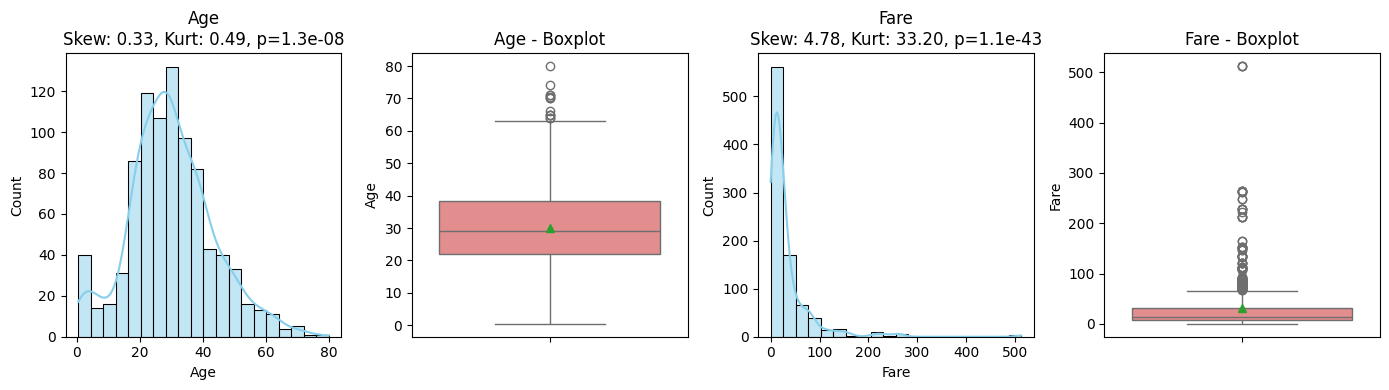

In [11]:
plot_numeric_distributions(data, numeric_cols)

## Cualitativas

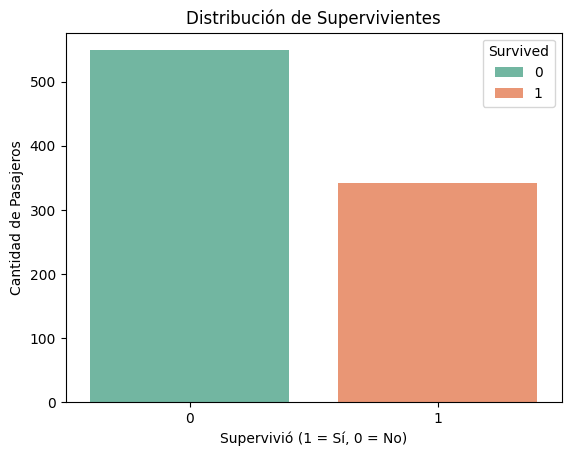

In [12]:
sns.countplot(data=data, x='Survived', hue='Survived', palette='Set2')
plt.title('Distribución de Supervivientes')
plt.xlabel('Supervivió (1 = Sí, 0 = No)')
plt.ylabel('Cantidad de Pasajeros')
plt.show()

In [13]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo,Family,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.2500,Unknown,S,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.2833,C85,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.1000,C123,S,Mrs,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.0500,Unknown,S,Mr,0,1
5,6,0,3,"Moran, Mr. James",male,22.684,0,0,330877,8.4583,Unknown,Q,Mr,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.8625,E46,S,Mr,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.0750,Unknown,S,Master,4,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.1333,Unknown,S,Mrs,2,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.0708,Unknown,C,Mrs,1,0


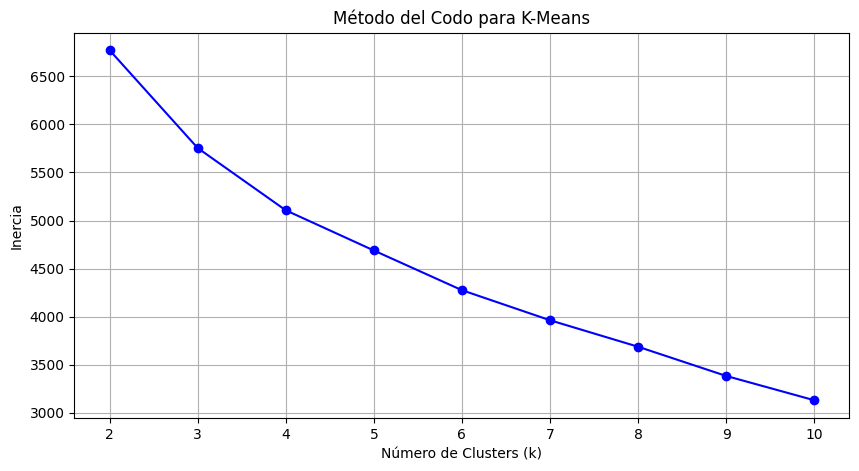


RESULTADOS DEL CLUSTERING (K=3)

Distribución de pasajeros por cluster:
Cluster
0    277
1    511
2    103
Name: count, dtype: int64


Características promedio por cluster:
         Survived  Pclass    Age   Fare  Family  IsAlone
Cluster                                                 
0            0.56    1.90  31.97  58.59    1.29     0.09
1            0.27    2.47  32.20  14.44    0.00     1.00
2            0.45    2.61  14.69  49.39    4.35     0.00


Distribución de Sexo por cluster:
Sex      female  male
Cluster              
0          0.57  0.43
1          0.20  0.80
2          0.50  0.50


Tasa de supervivencia por cluster:
         mean  count
Cluster             
0        0.56    277
1        0.27    511
2        0.45    103


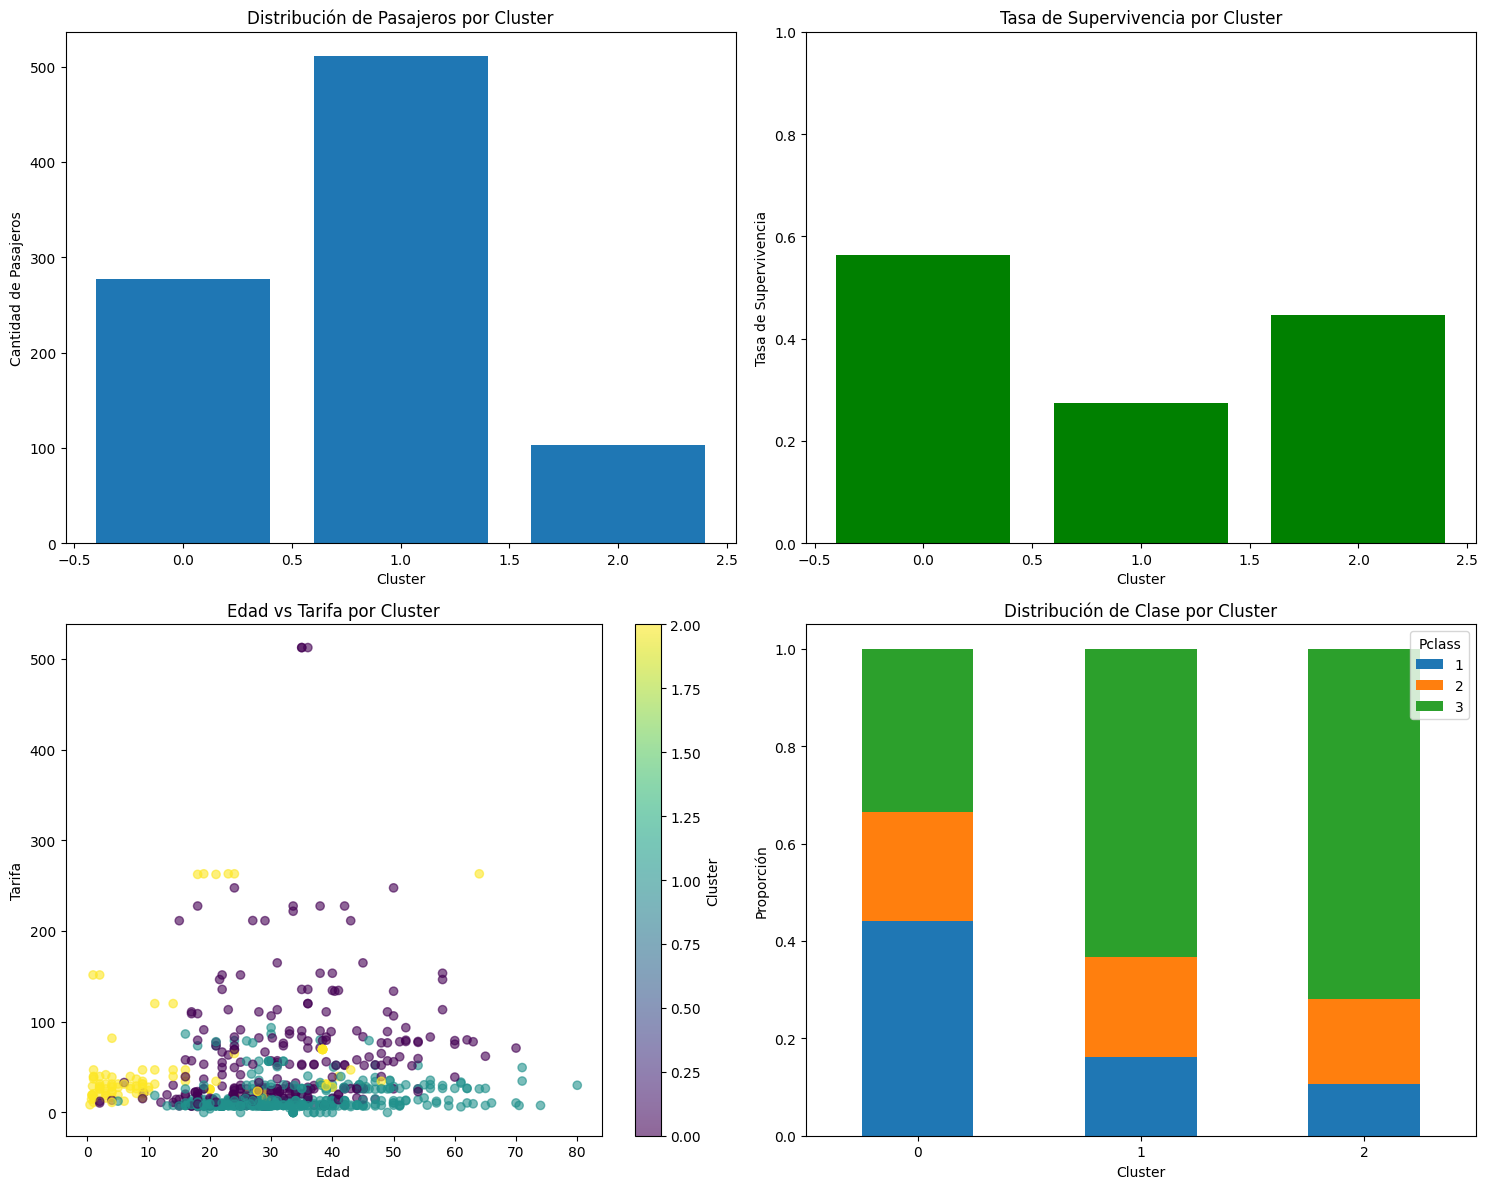


✓ Clustering completado. Columna 'Cluster' agregada al dataset 'data'


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos para clustering
df_cluster = data.copy()

# Seleccionar features relevantes para clustering
# Excluir: PassengerId, Name, Ticket, Cabin (alta cardinalidad), Survived (target)
features_numericas = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'IsAlone']
features_categoricas = ['Sex', 'Embarked', 'Titulo']

# Codificar variables categóricas
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
le_titulo = LabelEncoder()

df_cluster['Sex_encoded'] = le_sex.fit_transform(df_cluster['Sex'])
df_cluster['Embarked_encoded'] = le_embarked.fit_transform(df_cluster['Embarked'])
df_cluster['Titulo_encoded'] = le_titulo.fit_transform(df_cluster['Titulo'])

# Features finales para clustering
features_clustering = features_numericas + ['Sex_encoded', 'Embarked_encoded', 'Titulo_encoded']
X = df_cluster[features_clustering]

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Método del codo para encontrar k óptimo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualizar método del codo
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()

# Aplicar K-means con k=3 (ajusta según el método del codo)
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Agregar cluster al dataset original
data['Cluster'] = df_cluster['Cluster']

# Análisis de clusters
print(f"\n{'='*60}")
print(f"RESULTADOS DEL CLUSTERING (K={k_optimo})")
print(f"{'='*60}\n")

print("Distribución de pasajeros por cluster:")
print(data['Cluster'].value_counts().sort_index())

print("\n\nCaracterísticas promedio por cluster:")
caracteristicas = ['Survived', 'Pclass', 'Age', 'Fare', 'Family', 'IsAlone']
cluster_stats = data.groupby('Cluster')[caracteristicas].mean()
print(cluster_stats.round(2))

print("\n\nDistribución de Sexo por cluster:")
print(pd.crosstab(data['Cluster'], data['Sex'], normalize='index').round(2))

print("\n\nTasa de supervivencia por cluster:")
print(data.groupby('Cluster')['Survived'].agg(['mean', 'count']).round(2))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de clusters
axes[0, 0].bar(data['Cluster'].value_counts().sort_index().index, 
               data['Cluster'].value_counts().sort_index().values)
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Cantidad de Pasajeros')
axes[0, 0].set_title('Distribución de Pasajeros por Cluster')

# 2. Supervivencia por cluster
survival_by_cluster = data.groupby('Cluster')['Survived'].mean()
axes[0, 1].bar(survival_by_cluster.index, survival_by_cluster.values, color='green')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Tasa de Supervivencia')
axes[0, 1].set_title('Tasa de Supervivencia por Cluster')
axes[0, 1].set_ylim([0, 1])

# 3. Edad vs Fare coloreado por cluster
scatter = axes[1, 0].scatter(data['Age'], data['Fare'], c=data['Cluster'], 
                             cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Edad')
axes[1, 0].set_ylabel('Tarifa')
axes[1, 0].set_title('Edad vs Tarifa por Cluster')
plt.colorbar(scatter, ax=axes[1, 0], label='Cluster')

# 4. Clase vs Cluster
cluster_class = pd.crosstab(data['Cluster'], data['Pclass'], normalize='index')
cluster_class.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Proporción')
axes[1, 1].set_title('Distribución de Clase por Cluster')
axes[1, 1].legend(title='Pclass')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print(f"\n✓ Clustering completado. Columna 'Cluster' agregada al dataset 'data'")